<a href="https://colab.research.google.com/github/vgorchkova/inf2178-expdesignfordatascience-w23/blob/main/Group29_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import levene
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway

# **Clean the Dataset**

**The dataset include the individuals who are not strip searched**

In [2]:
# Import the dataset
url = "https://raw.githubusercontent.com/shionguha/inf2178-expdesignfordatascience-w23/main/project%20dataset/Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv"
df = pd.read_csv(url)

# Remove columns unnecessary to analysis
col = ['Arrest_Year', 'Arrest_Month', 'EventID', 'ArrestID', 'PersonID',\
       'Youth_at_arrest__under_18_years','Booked', 'Occurrence_Category',\
       'Actions_at_arrest___Cooperative',\
       'ItemsFound', 'ObjectId','ArrestLocDiv']

# Should use 0 to replace NaN, if we drop all NaN, we will lose individual who did not strip searched 
df_cleaned = df.drop(columns=col).fillna(0)

# Add a column called total number of SearchReasons, adding up reasons

df_cleaned['Total_Actions'] = df_cleaned.apply(lambda row: row['Actions_at_arrest___Concealed_i'] + row['Actions_at_arrest___Combative__'] + \
                                    row['Actions_at_arrest___Resisted__d'] + row['Actions_at_arrest___Mental_inst'] + \
                                                      row['Actions_at_arrest___Assaulted_o'], axis=1)
df_cleaned['Total_Search'] = df_cleaned['Total_SearchReason'] = df_cleaned.apply(lambda row: row['SearchReason_CauseInjury'] + row['SearchReason_AssistEscape'] + \
                                    row['SearchReason_PossessWeapons'] + row['SearchReason_PossessEvidence'], axis=1)
df_cleaned = df_cleaned.drop(['Actions_at_arrest___Concealed_i',\
       'Actions_at_arrest___Combative__', 'Actions_at_arrest___Resisted__d',\
       'Actions_at_arrest___Assaulted_o','Actions_at_arrest___Mental_inst',\
       'SearchReason_CauseInjury', 'SearchReason_AssistEscape', \
       'SearchReason_PossessWeapons', 'SearchReason_PossessEvidence','Total_Search'], axis=1)


# Remove columns with 'Unknown or Legacy' for perceived race.
df_cleaned.drop(df_cleaned[df_cleaned['Perceived_Race'] == "Unknown or Legacy"].index, inplace = True)

# Remove the 'U' Sex, since there are only 6 in the entire dataset.
df_cleaned.drop(df_cleaned[df_cleaned['Sex'] == "U"].index, inplace = True)

# #Rename columns to be more legible
df_cleaned.rename(columns={'Perceived_Race':'Race',"Age_group__at_arrest_":"Age_Group"}, inplace=True)

# convert the  "Total_SearchReason" column from float to int
df_cleaned['Total_SearchReason'] = df_cleaned['Total_SearchReason'].astype(int)

#Categrical level are repeated, thus, converge 'Aged 17 years and under' to 'Aged 17 years and younger', and 'Aged 65 and older' to 'Aged 65 years and older'
df_cleaned['Age_Group'] = df_cleaned['Age_Group'].replace(['Aged 17 years and under','Aged 65 and older'],[ 'Aged 17 years and younger','Aged 65 years and older'])

#Remove 0 for Age_Group and Race Since we replace NaN to 0 before)
df_cleaned = df_cleaned[(df_cleaned['Race'] != 0) & (df_cleaned['Age_Group'] != 0)]

#Reset index
df_cleaned = df_cleaned.reset_index(drop = True)

#age group convert to continous variable (Integer)
df_cleaned['Age_Group'] = df_cleaned['Age_Group'].replace(['Aged 17 years and younger','Aged 18 to 24 years','Aged 25 to 34 years',\
                                                          'Aged 35 to 44 years','Aged 45 to 54 years','Aged 55 to 64 years','Aged 65 years and older'],\
                                                          [ '17','21','30','40','50','60','65']).astype(int)
df_cleaned

,Race,Sex,Age_Group,StripSearch,Total_Actions,Total_SearchReason
0,White,M,40,0,0,0
1,White,M,40,0,0,0
2,Black,M,30,0,0,0
3,South Asian,M,30,0,0,0
4,South Asian,M,30,0,0,0
...,...,...,...,...,...,...
60182,White,F,30,0,0,0
60183,Indigenous,F,30,0,1,0
60184,South Asian,M,40,0,0,0
60185,White,F,50,0,0,0


**Dataset for individual who strip searched**

In [3]:
df_cleaned_SS = df_cleaned.loc[df_cleaned['StripSearch'].isin([1])]
df_cleaned_SS

,Race,Sex,Age_Group,StripSearch,Total_Actions,Total_SearchReason
11,Black,M,30,1,0,3
13,Black,M,30,1,0,3
27,White,M,40,1,0,2
32,Latino,M,21,1,0,2
36,South Asian,F,30,1,0,1
...,...,...,...,...,...,...
58911,Black,M,30,1,0,2
59089,White,M,40,1,0,0
59209,South Asian,M,30,1,0,1
59313,Black,M,17,1,0,2


# **EDA**

**RACE FREQUENCY BARPLOT**

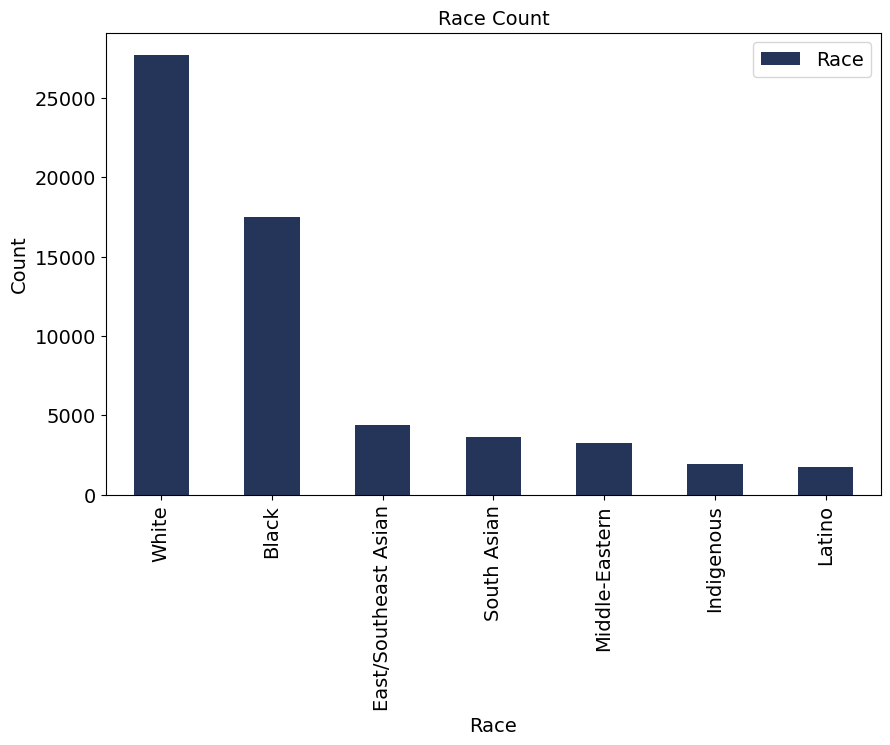

In [4]:
count_table_race = df_cleaned.value_counts(df_cleaned["Race"])

# Create a bar plot of the count table
race_bar = count_table_race.plot.bar(figsize=(10, 6),fontsize = 14, color='#25355A')

# Set the title and axis labels
race_bar.set_title('Race Count',fontsize = 14)
race_bar.set_xlabel('Race',fontsize = 14)
race_bar.set_ylabel('Count',fontsize = 14)

# Add a legend
race_bar.legend(['Race'],fontsize = 14)

**GENDER FREQUENCY BAR PLOT**

Text(0, 0.5, 'Count')

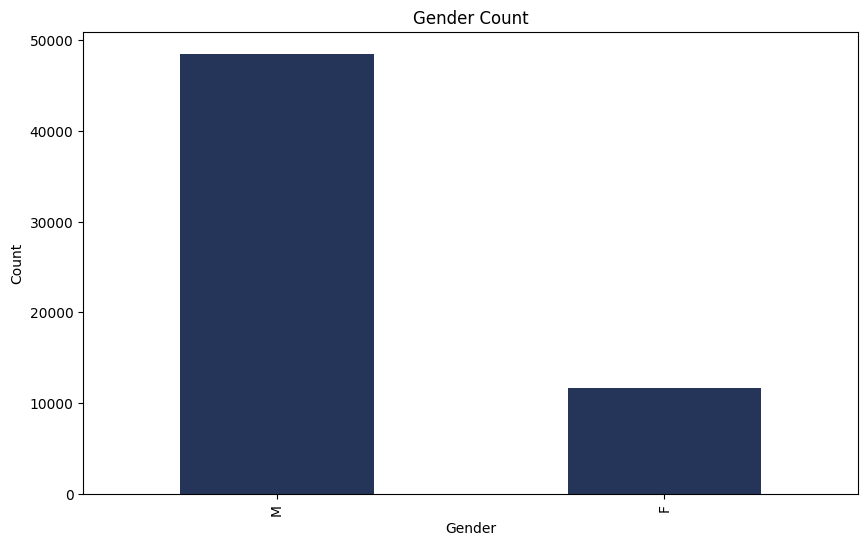

In [5]:
count_table_Sex = df_cleaned.value_counts(df_cleaned["Sex"])
count_table_Sex = count_table_Sex.plot.bar(figsize=(10, 6),color='#25355A')

count_table_Sex.set_title('Gender Count')
count_table_Sex.set_xlabel('Gender')
count_table_Sex.set_ylabel('Count')

**Age frequency barplot**

Text(0, 0.5, 'Count')

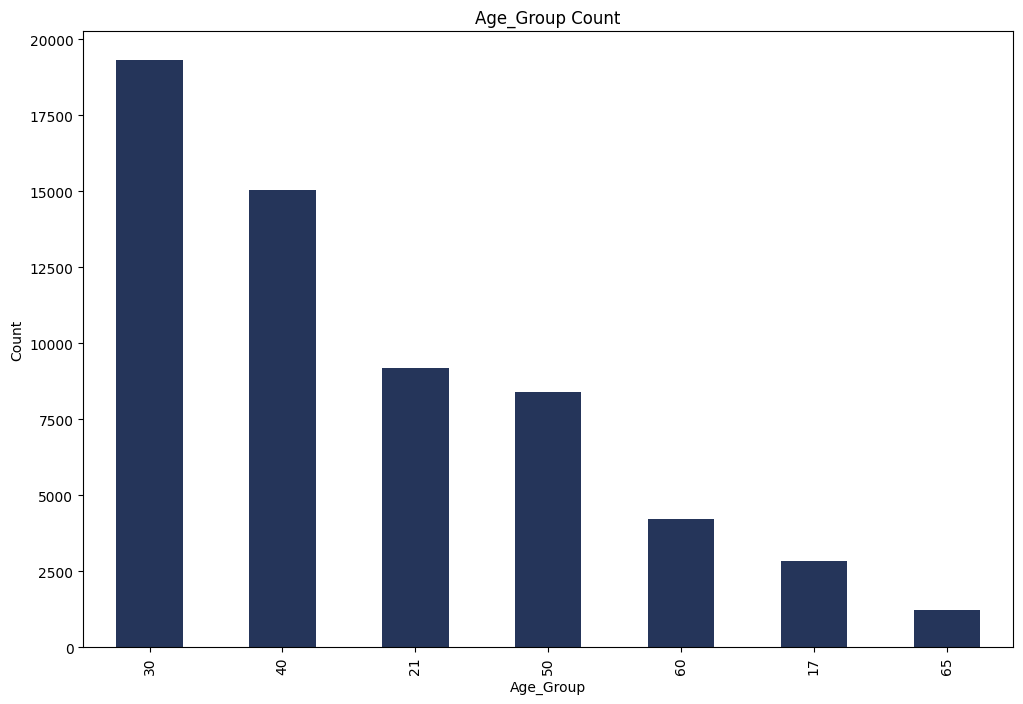

In [6]:
count_table_Age_Group = df_cleaned.value_counts(df_cleaned["Age_Group"])
count_table_Age_Group = count_table_Age_Group.plot.bar(figsize=(12, 8),color='#25355A')

count_table_Age_Group.set_title('Age_Group Count')
count_table_Age_Group.set_xlabel('Age_Group')
count_table_Age_Group.set_ylabel('Count')

**Stripsearch barplot**

Text(0, 0.5, 'Count')

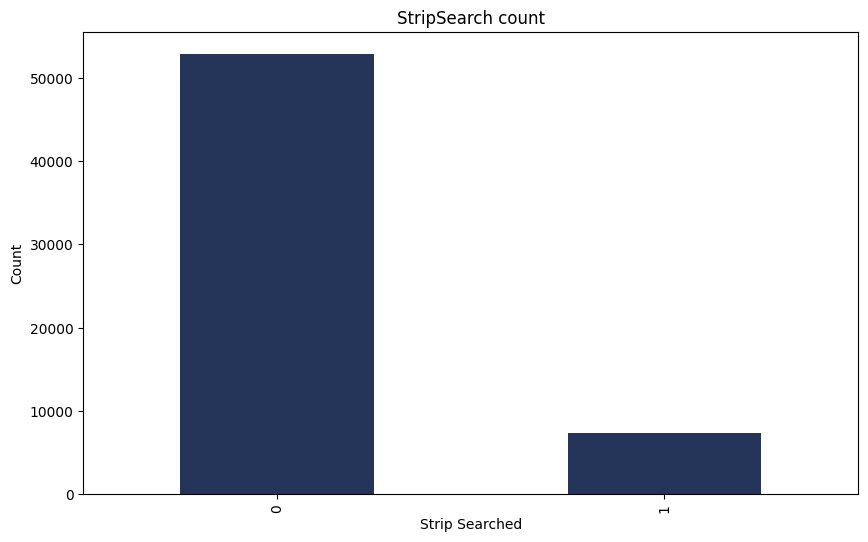

In [7]:
count_table_strip = df_cleaned.value_counts(df_cleaned["StripSearch"])
strip_bar = count_table_strip.plot.bar(figsize=(10, 6),color='#25355A')

strip_bar.set_title('StripSearch count')
strip_bar.set_xlabel('Strip Searched')
strip_bar.set_ylabel('Count')

**Pivot Table and plot for probability of StripSearch by Race**

In [8]:
pivot_Race_SS = pd.pivot_table(df_cleaned,index ='Race', values='StripSearch')
pivot_Race_SS

,StripSearch
Race,
Black,0.138943
East/Southeast Asian,0.077289
Indigenous,0.158385
Latino,0.074703
Middle-Eastern,0.070436
South Asian,0.071132
White,0.128699


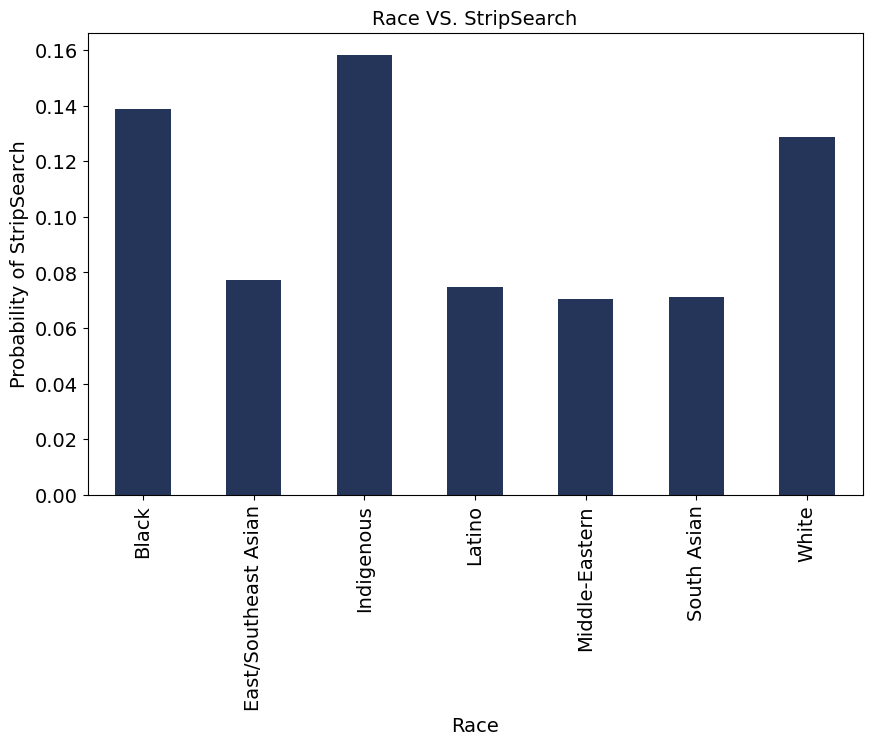

In [9]:
race_SS_bar = pivot_Race_SS.plot.bar(figsize=(10, 6),fontsize = 14, color='#25355A')

race_SS_bar.set_title('Race VS. StripSearch',fontsize = 14)
race_SS_bar.set_xlabel('Race',fontsize = 14)
race_SS_bar.set_ylabel('Probability of StripSearch',fontsize = 14)
race_SS_bar.legend().remove()

**Pivot Table for probability of StripSearch by SEX**

In [10]:
pivot_Sex_SS = pd.pivot_table(df_cleaned,index ='Sex', values='StripSearch')
pivot_Sex_SS

,StripSearch
Sex,
F,0.101609
M,0.125286


**Pivot Table for probability of StripSearch by Age**

In [11]:
pivot_Age_SS = pd.pivot_table(df_cleaned,index ='Age_Group', values='StripSearch')
pivot_Age_SS

,StripSearch
Age_Group,
17,0.091681
21,0.135577
30,0.132701
40,0.130781
50,0.101489
60,0.081893
65,0.027228


**BOX PLOT race, searchreason, sex**

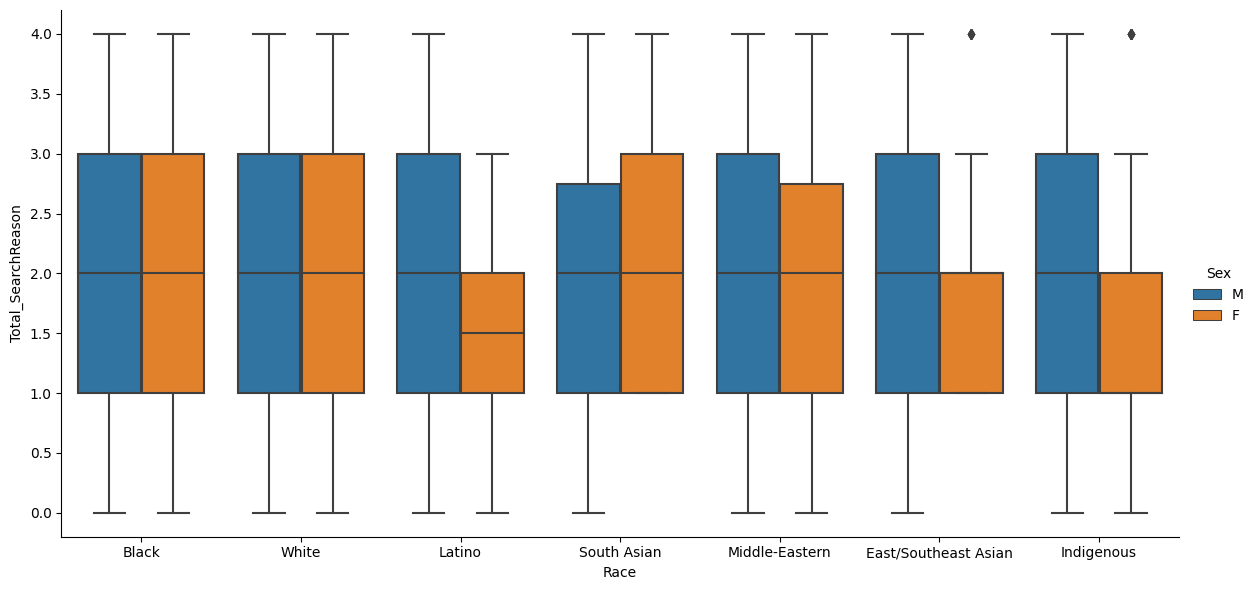

In [12]:
import seaborn as sns
#for stripsearched individual
df_cleaned_SS = df_cleaned.loc[df_cleaned['StripSearch'].isin([1])]
sns.catplot(data=df_cleaned_SS, kind="box", x="Race", y="Total_SearchReason", hue="Sex",height=6, aspect=2)

BOX PLOT Age, searchreason, sex

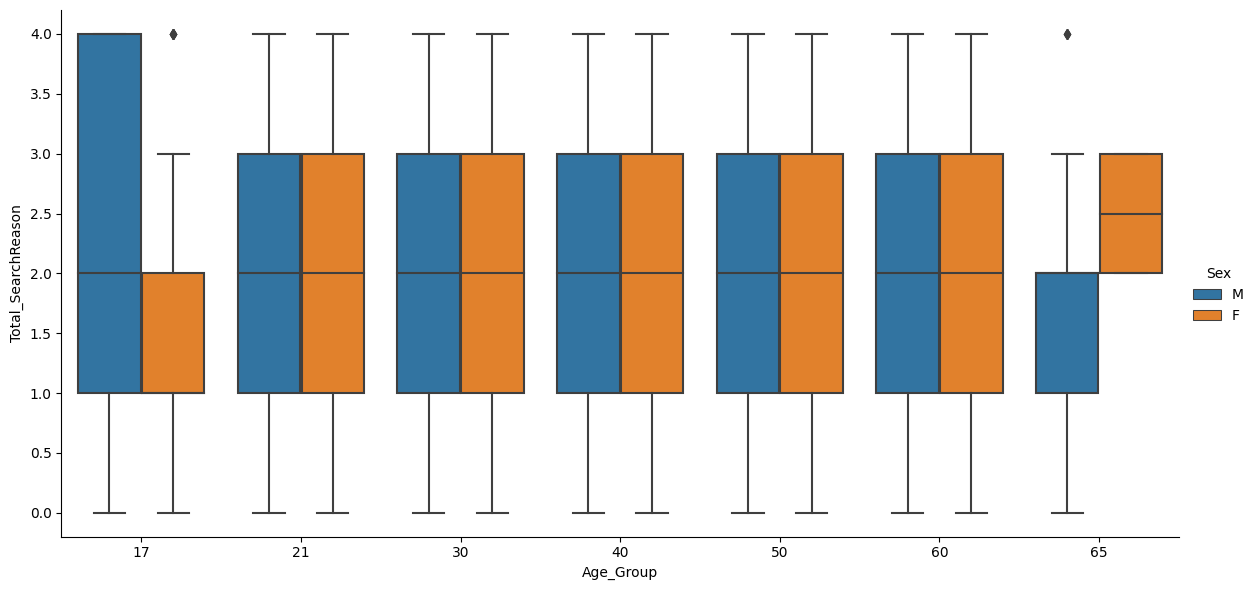

In [13]:
#for stripsearched individual
sns.catplot(data=df_cleaned_SS, kind="box", x="Age_Group", y="Total_SearchReason", hue="Sex",height=6, aspect=2)

**chi-square for race and StripSearch**

In [14]:
from scipy.stats import chi2_contingency
# create a contingency table
table = pd.crosstab(df_cleaned['StripSearch'], df_cleaned['Race'])

# perform the chi-square test
stat, p, dof, expected = chi2_contingency(table)


# print the results
print('Chi-square test statistic:', stat)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected frequencies:', expected)

Chi-square test statistic: 371.78137715055516
p-value: 3.2423319878332747e-77
Degrees of freedom: 6
Expected frequencies: [[15403.74356589  3879.51344975  1698.82592586  1553.73986077
   2846.32480436  3176.94517088 24363.90722249]
 [ 2114.25643411   532.48655025   233.17407414   213.26013923
    390.67519564   436.05482912  3344.09277751]]


**chi-square for Sex and StripSearch**

In [15]:
from scipy.stats import chi2_contingency
# create a contingency table
table_SSS = pd.crosstab(df_cleaned['StripSearch'], df_cleaned['Sex'])

# perform the chi-square test
stat, p, dof, expected = chi2_contingency(table_SSS)


# print the results
print('Chi-square test statistic:', stat)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected frequencies:', expected)

Chi-square test statistic: 49.5084575578152
p-value: 1.9751837256274486e-12
Degrees of freedom: 1
Expected frequencies: [[10272.09340888 42650.90659112]
 [ 1409.90659112  5854.09340888]]


**chi-square for Age and StripSearch**

In [16]:
# create a contingency table
table_AS = pd.crosstab(df_cleaned['StripSearch'], df_cleaned['Age_Group'])

# perform the chi-square test
stat, p, dof, expected = chi2_contingency(table_AS)


# print the results
print('Chi-square test statistic:', stat)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('Expected frequencies:', expected)

Chi-square test statistic: 271.1013501772278
p-value: 1.2608713861164803e-55
Degrees of freedom: 6
Expected frequencies: [[ 2484.04929636  8074.69900477 16969.79375945 13231.84913686
   7381.80313024  3715.08257597  1065.72309635]
 [  340.95070364  1108.30099523  2329.20624055  1816.15086314
   1013.19686976   509.91742403   146.27690365]]


**t test Race vs SearchReason for people who strip searched**

In [17]:
# levene to test whether have same population variance
from scipy.stats import levene

# data for two groups
white_data = df_cleaned_SS[df_cleaned_SS['Race']=='White']
black_data = df_cleaned_SS[df_cleaned_SS['Race']=='Black']
white = white_data['Total_SearchReason']
black = black_data['Total_SearchReason']
# conduct Levene's test
stat, pvalue = levene(white, black)

# print the test statistic and p-value
print('levene Test statistic:', stat)
print('levene P-value:', pvalue)

#CI for race vs total search reason
from scipy.stats import ttest_ind

#calculate the t-statistic and p-value
t_p = ttest_ind(white,black)
print('Ttest results for # of reasons for strip searching White and Black arrestees:',t_p)

#degrees of freedom
df = len(white) + len(black) - 2

#calculate the confidence interval for the difference in means
mean_difference = np.mean(white) - np.mean(black)
sd_difference = np.sqrt((np.var(white) / len(white)) + (np.var(black) / len(black)))
#95% CI
margin_error = 1.96 * sd_difference 
CI_RR = (mean_difference - margin_error, mean_difference + margin_error)

# print the results
print("degrees of freedom: ", df)
print("Mean of total number of reasons for the White arrestees: ", np.mean(white))
print("Mean of total number of reasons for the Black arrestees: ", np.mean(black))
print("Standard deviation of total number of reasons for the White arrestees: ", np.std(white))
print("Standard deviation of total number of reasons for the Black arrestees: ", np.std(black))
print("confidence interval: ", CI_RR)

levene Test statistic: 1.930249992122145
levene P-value: 0.16478266968593444
Ttest results for # of reasons for strip searching White and Black arrestees: Ttest_indResult(statistic=-2.0180774278207982, pvalue=0.04362763265896725)
degrees of freedom:  5998
Mean of total number of reasons for the White arrestees:  1.9649467190128995
Mean of total number of reasons for the Black arrestees:  2.0291700903861956
Standard deviation of total number of reasons for the White arrestees:  1.2127360152573845
Standard deviation of total number of reasons for the Black arrestees:  1.206482239164465
confidence interval:  (-0.1265272859404273, -0.001919456806164753)


**t test Race vs Total actions at arrest for people who strip searched**

In [18]:
# data for two groups
white_data_1 = df_cleaned_SS[df_cleaned_SS['Race']=='White']
black_data_1 = df_cleaned_SS[df_cleaned_SS['Race']=='Black']
white_1 = white_data_1['Total_Actions']
black_1 = black_data_1['Total_Actions']

# levene to test whether have same population variance
from scipy.stats import levene


# conduct Levene's test
stat, pvalue = levene(white_1, black_1)

# print the test statistic and p-value
print('Levene Test statistic:', stat)
print('Levene test P-value:', pvalue)



#since population variance might uneuqal, so use weltch t test
#degree of freedom
def welch_dof(x, y): 
    '''
    Takes in final grades for binary features
    Returns degrees of freedom 
    '''
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
    return dof
print('degree of freedom:',welch_dof(white_1,black_1))

#weltch t test
t_p_action = stats.ttest_ind(white_1, black_1, equal_var=False)
print('Ttest results for # of actions the White and Black who are strip searched :',t_p_action) 

# mean and sd
print('Mean of total number of actions for White and Black who are strip searched:',white_1.mean(), black_1.mean())
print('Standard deviation of total number of actions for white and black who are strip searched :',white_1.std(), black_1.std())

#Confidence interval
import statsmodels.stats.api as sms
CI_action = sms.CompareMeans(sms.DescrStatsW(white_1), sms.DescrStatsW(black_1))
print('Confidence interval :',CI_action.tconfint_diff(usevar='unequal'))

Levene Test statistic: 19.53306036861891
Levene test P-value: 1.0061556389580791e-05
degree of freedom: 4762.8666557312845
Ttest results for # of actions the White and Black who are strip searched : Ttest_indResult(statistic=-4.312218150819922, pvalue=1.6489231098716865e-05)
Mean of total number of actions for White and Black who are strip searched: 0.23022994952327538 0.3011503697617091
Standard deviation of total number of actions for white and black who are strip searched : 0.5762920629149696 0.6570171291528663
Confidence interval : (-0.10316294535720323, -0.03867789511966423)


**t test Gender vs Total search reason for people who strip searched**

In [19]:
female = df_cleaned_SS[df_cleaned_SS["Sex"]=="F"]
male = df_cleaned_SS[df_cleaned_SS["Sex"]=="M"]
# conduct Levene's test
stat, pvalue = levene(female["Total_SearchReason"], male["Total_SearchReason"])

# print the LEVENE test statistic and p-value
print('levene Test statistic for variances:', stat)
print('levene P-value for variances:', pvalue)


print('Mean of total number of reasons for Females and Males who are strip searched:',female["Total_SearchReason"].mean(), male["Total_SearchReason"].mean())
print('Standard deviation of total number of reasons for Females and Males who are strip searched :',female["Total_SearchReason"].std(), male["Total_SearchReason"].std())

t_p = stats.ttest_ind(female['Total_SearchReason'], male["Total_SearchReason"])
print('Ttest results for # of reasons for strip searching female and male arrestees:',t_p)

#Confidence interval
import statsmodels.stats.api as sms
CI_SS = sms.CompareMeans(sms.DescrStatsW(female["Total_SearchReason"]), sms.DescrStatsW(male["Total_SearchReason"]))
print('Confidence interval :',CI_SS.tconfint_diff(usevar='pooled'))
#dof
dof_g_s = len(female["Total_SearchReason"]) + len(male["Total_SearchReason"]) - 2
print('degree of freedom',dof_g_s)

levene Test statistic for variances: 1.0154274425305339
levene P-value for variances: 0.31363966752263855
Mean of total number of reasons for Females and Males who are strip searched: 1.8711036225779276 2.0093796281059735
Standard deviation of total number of reasons for Females and Males who are strip searched : 1.17996157590798 1.2116714445205097
Ttest results for # of reasons for strip searching female and male arrestees: Ttest_indResult(statistic=-3.6114672766159983, pvalue=0.0003065241185617491)
Confidence interval : (-0.21333169561286502, -0.06322031544322669)
degree of freedom 7262


**t test Gender vs Total Actions at arrest for people who strip searched**

In [20]:
female_1 = df_cleaned_SS[df_cleaned_SS["Sex"]=="F"]
male_1 = df_cleaned_SS[df_cleaned_SS["Sex"]=="M"]

# conduct Levene's test
stat, pvalue = levene(female_1["Total_Actions"], male_1["Total_Actions"])

# print the test statistic and p-value
print('levene Test statistic for variances:', stat)
print('levene P-value for variances:', pvalue)


print('Mean of total number of actions for Females and Males who are strip searched:',female_1["Total_Actions"].mean(), male_1["Total_Actions"].mean())
print('Standard deviation of total number of actions for Females and Males who are strip searched :',female_1["Total_Actions"].std(), male_1["Total_Actions"].std())

t_p_1 = stats.ttest_ind(female_1['Total_Actions'], male_1["Total_Actions"])
print('Ttest results for # of actions for strip searching White and Black arrestees:',t_p_1)
#Confidence interval
import statsmodels.stats.api as sms
CI_SA = sms.CompareMeans(sms.DescrStatsW(female_1["Total_Actions"]), sms.DescrStatsW(male_1["Total_Actions"]))
print('Confidence interval :',CI_SA.tconfint_diff(usevar='pooled'))
#dof
dof_g_a = len(female_1["Total_Actions"]) + len(male_1["Total_Actions"]) - 2
print('degree of freedom',dof_g_a)

levene Test statistic for variances: 0.6330922867703639
levene P-value for variances: 0.42624931290143375
Mean of total number of actions for Females and Males who are strip searched: 0.2443133951137321 0.25966759914431464
Standard deviation of total number of actions for Females and Males who are strip searched : 0.5987262445107537 0.6099143207819518
Ttest results for # of actions for strip searching White and Black arrestees: Ttest_indResult(statistic=-0.7956709663990285, pvalue=0.42624931290438584)
Confidence interval : (-0.05318228215412965, 0.022473874092964558)
degree of freedom 7262


# **power analysis for one of the t-test: sex vs. total search resason.**

In [21]:
from statsmodels.stats.power import TTestIndPower

#code for Cohen's D 

#function to calculate the pooled standard deviation of 2 samples
def pooled_standard_deviation(sample1,sample2):
    #calculate the sample size
    n1, n2 = len(sample1), len(sample2)
    #calculate the variances
    var1, var2 = np.var(sample1, ddof=1), np.var(sample2, ddof=1)
    #calculate the pooled standard deviation
    numerator = ((n1-1) * var1) + ((n2-1) * var2)
    denominator = n1+n2-2
    return np.sqrt(numerator/denominator)
# function to calculate Cohen's d for independent samples

def Cohens_d(sample1, sample2):
    u1, u2 = np.mean(sample1), np.mean(sample2)
    s_pooled = pooled_standard_deviation(sample1, sample2)
    #print(s_pooled)
    return ((u1 - u2) / s_pooled)

In [22]:
# effective size
effect_size = Cohens_d(white,black)
alpha = 0.05
power = 0.8
ratio_ =len(white)/len(black) #NB: ratio = nobs2/nobs1
print('Effect size (Cohen\'s D) for Search reason based on race:',effect_size)

#propsed sample size
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=ratio_, alpha=alpha)
print('Sample Size of nobs1: %.3f' % sample_size, 'needed for black') 
print('Actual size of black:', len(black))
nobs2 =ratio_*sample_size
print('Sample Size of nobs2: %.3f' % nobs2, 'needed for white')
print('Actual size of white:', len(white))

#power of the actual test
from statsmodels.stats.power import TTestPower

power = TTestPower()
n_test = power.solve_power(nobs = 2434, effect_size = effect_size , power = None, alpha = 0.05)
print('Power for actual sample size: {:.3f}'.format(n_test))

Effect size (Cohen's D) for Search reason based on race: -0.05305941943024864
Sample Size of nobs1: 4691.629 needed for black
Actual size of black: 2434
Sample Size of nobs2: 6873.603 needed for white
Actual size of white: 3566
Power for actual sample size: 0.744


/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: invalid value encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


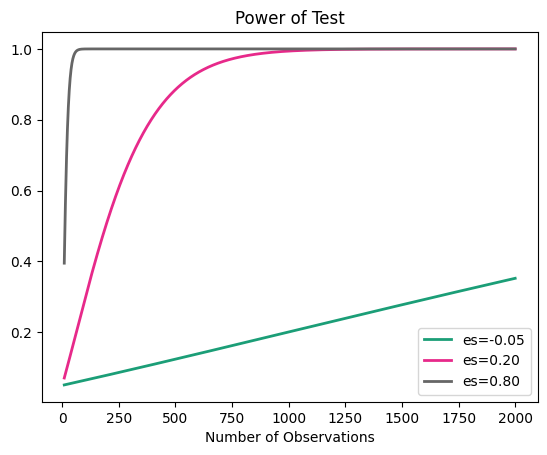

In [23]:
effect_sizes = np.array([-0.05, 0.2, 0.8])
total_sample_sizes = np.array(range(10,2000))

# plot power curves
analysis = TTestIndPower()
analysis.plot_power(dep_var='nobs', nobs=total_sample_sizes, effect_size = effect_sizes,)

plt.show()

# **power analysis to find proposed sample size of ANCOVA**

In [24]:
import statsmodels.stats.power as smp

# Number of groups
k = 2

# Desired effect size (Cohen's f)
f = 0.25

# Desired power
power = 0.8

# Significance level (alpha)
alpha = 0.05

# Perform power analysis to find sample size
anova_power = smp.FTestAnovaPower()
sample_size = anova_power.solve_power(effect_size=f, nobs=None, alpha=alpha, power=power)

print("Number of groups (k):", k)
print("Effect size (Cohen's f):", f)
print("Power:", power)
print("Significance level (alpha):", alpha)
print("Proposed sample size per group:", round(sample_size))

Number of groups (k): 2
Effect size (Cohen's f): 0.25
Power: 0.8
Significance level (alpha): 0.05
Proposed sample size per group: 128


# **ANCOVA**

**Ancova- total search reason vs. gender when control age**




In [25]:
!pip install pingouin
from pingouin import ancova
ancova(data=df_cleaned_SS, dv='Total_SearchReason', covar='Age_Group', between='Sex')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=72ef7bf2177cd5edae2a9e0d28aba8ea81fc9e46dccf575bbccb0d5bbcb98fb7
  Stored in directory: /root/.cache/pip/wheels/04/bb/0d/2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built littleutils


,Source,SS,DF,F,p-unc,np2
0,Sex,20.459487,1,14.095284,0.000175,0.001937
1,Age_Group,32.308600,1,22.258568,0.000002,0.003056
2,Residual,10539.435615,7261,NaN,NaN,NaN


**Ancova- total search reason vs race when control age**

In [26]:
ancova(data=df_cleaned_SS, dv='Total_SearchReason', covar='Age_Group', between='Race')

,Source,SS,DF,F,p-unc,np2
0,Race,9.881774,6,1.132734,0.340213,0.000936
1,Age_Group,26.361787,1,18.130890,0.000021,0.002493
2,Residual,10550.013329,7256,NaN,NaN,NaN


**Ancova- total actions at arrest vs. race when control age**




In [27]:
ancova(data=df_cleaned_SS, dv='Total_Actions', covar='Age_Group', between='Race')

,Source,SS,DF,F,p-unc,np2
0,Race,11.486780,6,5.195426,0.000024,4.277730e-03
1,Age_Group,0.000023,1,0.000063,0.993681,8.645020e-09
2,Residual,2673.764511,7256,NaN,NaN,NaN


**Ancova- total actions at arrest vs. Sex when control age**

In [28]:
ancova(data=df_cleaned_SS, dv='Total_Actions', covar='Age_Group', between='Sex')

,Source,SS,DF,F,p-unc,np2
0,Sex,0.252174,1,0.681950,0.408943,0.000094
1,Age_Group,0.394527,1,1.066913,0.301678,0.000147
2,Residual,2684.999117,7261,NaN,NaN,NaN


# **Power analysis for ANCOVA TO TEST THE POWER**

In [29]:
import statsmodels.stats.power as smp

# Number of groups
k = 2

# Sample size per group
n = 7264

# Effect size (Cohen's f)
f = 0.25

# Significance level (alpha)
alpha = 0.05

# Perform power analysis
anova_power = smp.FTestAnovaPower()
power = anova_power.solve_power(effect_size=f, nobs=n, alpha=alpha)

print("Number of groups (k):", k)
print("Sample size per group (n):", n)
print("Effect size (Cohen's f):", f)
print("Significance level (alpha):", alpha)
print("Power:", power)

Number of groups (k): 2
Sample size per group (n): 7264
Effect size (Cohen's f): 0.25
Significance level (alpha): 0.05
Power: 1.0


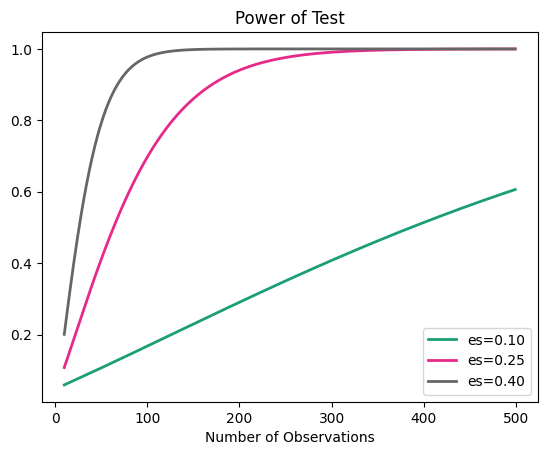

In [30]:
# power analysis varying parameters
effect_sizes = np.array([0.1, 0.25,0.4])
sample_sizes = np.array(range(10, 500))

# plot power curves
obj = smp.FTestAnovaPower()
obj.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)

plt.show()

#Logistic Regression
After conducting the analysis we can create a logistic regression model to further investigate the data 

In [31]:
# Preparing Dataset for LR Model
df_LR = df_cleaned
df_LR['RaceCode'] = df_LR["Race"].map({'Black': 0, 'White': 1, 'East/Southeast Asian' :0,"Indigenous":0, "Latino":0, "Middle-Eastern":0, "South Asian":0})
df_LR.drop("Race", axis=1, inplace=True)
df_LR.drop("Total_SearchReason", axis=1, inplace=True)
df_cleaned

,Sex,Age_Group,StripSearch,Total_Actions,RaceCode
0,M,40,0,0,1
1,M,40,0,0,1
2,M,30,0,0,0
3,M,30,0,0,0
4,M,30,0,0,0
...,...,...,...,...,...
60182,F,30,0,0,1
60183,F,30,0,1,0
60184,M,40,0,0,0
60185,F,50,0,0,1


In [32]:
from sklearn.model_selection import train_test_split

# Predictors for the response column
sex_dummies = pd.get_dummies(df_LR["Sex"], drop_first=True)
x = pd.concat([df_cleaned[["Age_Group", "Total_Actions", "RaceCode"]],sex_dummies], axis=1)
 

# Response column
y = df_LR["StripSearch"]

# Splitting the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [95]:
#building the model with statsmodels

import statsmodels.api as sm
import seaborn as sns

# Fit a logistic regression model
model = sm.Logit(y_train, X_train)
result = model.fit()
#model = sm.Logit(y_train, X_train).fit()

# Print a summary of the model
print(result.summary())
     

Optimization terminated successfully.
         Current function value: 0.376067
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            StripSearch   No. Observations:                48149
Model:                          Logit   Df Residuals:                    48145
Method:                           MLE   Df Model:                            3
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:                -0.02294
Time:                        19:11:19   Log-Likelihood:                -18107.
converged:                       True   LL-Null:                       -17701.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Age_Group        -0.0491      0.001    -58.616      0.000      -0.051      -0.047
Total_Actions     0.

In [125]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# Code used from the github Notebook
# Predict responses 
pred_1 = result.predict(X_test)
# round() rounds to nearest integer;
# 0.5 rounds to 0; 0.501 rounds to 1
prediction_1 = list(map(round, pred_1))


# Accuracy score
print('\nTest accuracy = ', accuracy_score(y_test, prediction_1))


# Confusion matrix
## Test accuracy =  0.8779697624190065

cm = confusion_matrix(y_test, prediction_1) 
print ("\nConfusion Matrix : \n", cm) 

f1 = f1_score(y_test, prediction_1)
print("\nF1 Score: \n", f1)


Test accuracy =  0.877222129921914

Confusion Matrix : 
 [[10555    14]
 [ 1464     5]]

F1 Score: 
 0.006720430107526882


In [127]:
# Odds Ratio Calculation
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ["Lower CI", "Upper CI", "OR"]
np.exp(conf)

,Lower CI,Upper CI,OR
Age_Group,0.950569,0.953693,0.952130
Total_Actions,1.535006,1.695191,1.613111
RaceCode,1.006803,1.122652,1.063151
M,0.642244,0.716556,0.678383


**ROC Curve and AUC For the Logistic Regression Model**

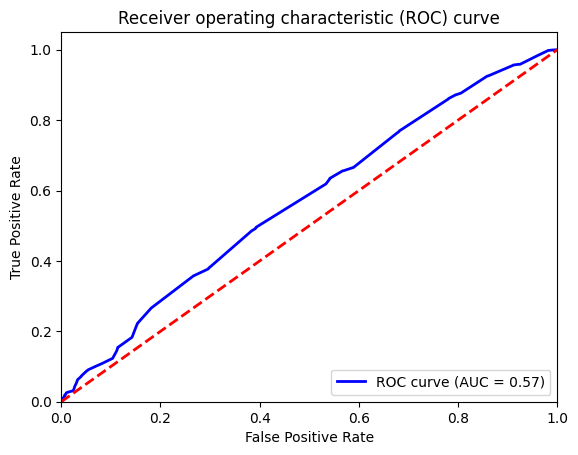

In [100]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Compute the false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = roc_curve(y_test, pred_1)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

**Calculating the prediction interval for the logistic regression model.**


In [101]:
# Calculate prediction interval
# Compute the prediction variance
pred_var = np.mean((pred_1 - y_test)**2)

# Compute the standard error of the predicted values
se = np.sqrt(pred_var / X_test.shape[0])

# Set the desired level of confidence (e.g., 95%)
conf_level = 0.95

# Compute the z-score corresponding to the desired confidence level
z_score = 1.96

# Compute the upper and lower bounds of the prediction interval
upper_bound = pred_1 + z_score * se
lower_bound = pred_1 - z_score * se

In [149]:
# Create dataframe to plot prediction interval
plot_df = pd.concat([y_test, pred_1, upper_bound, lower_bound],axis=1)
plot_df = plot_df.rename(columns={'StripSearch': 'Actual', 0: 'Predicted', 1: 'Upper Bound', 2: 'Lower Bound'})

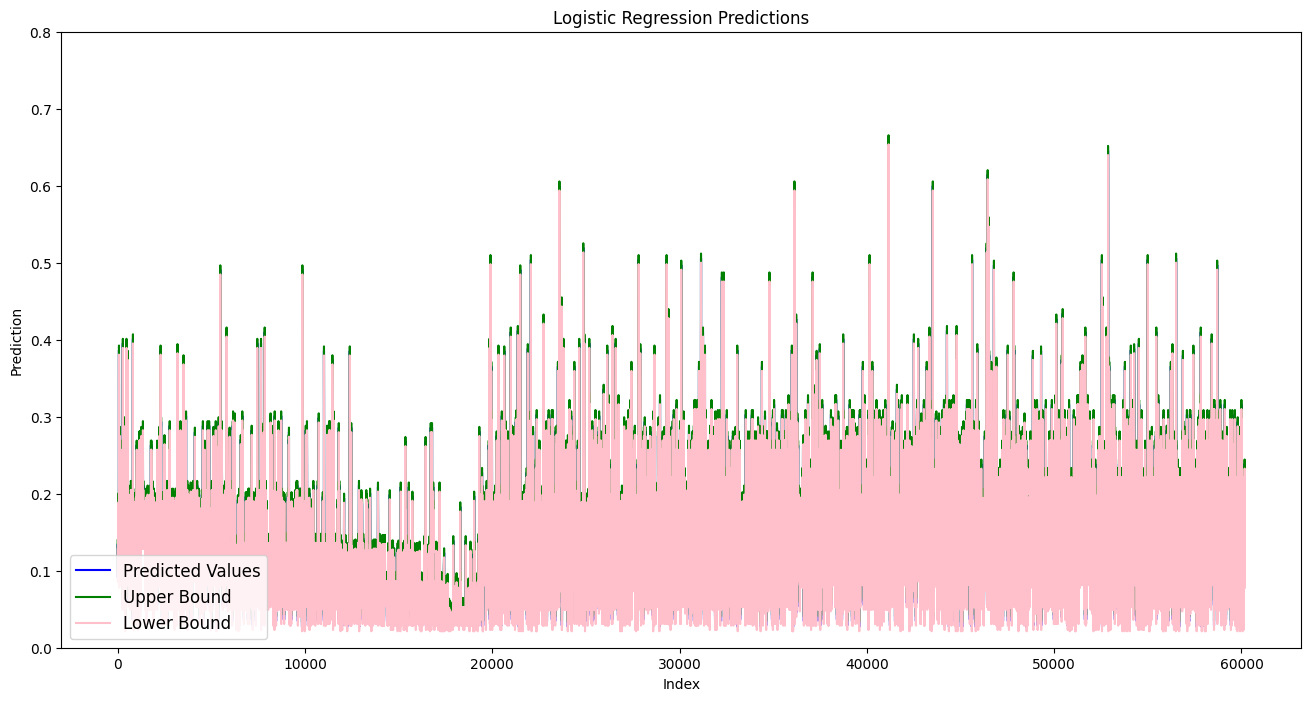

In [154]:
sorted = plot_df.sort_index()
# Make a plot of model fit

fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(111)


x = plot_df.index.values

plt.title('Logistic Regression Predictions')

plt.xlabel('Index')
plt.ylabel('Prediction')

upper = sorted['Upper Bound']
lower = sorted['Lower Bound']

sorted['Predicted'].plot(color = 'blue', label = 'Predicted Values')
upper.plot(color = 'green', label = 'Upper Bound')
lower.plot(color = 'pink', label = 'Lower Bound')

# plot the legend for the first plot
plt.legend(loc = 'lower left', fontsize = 12)

plt.ylim(0,0.8)

plt.show()


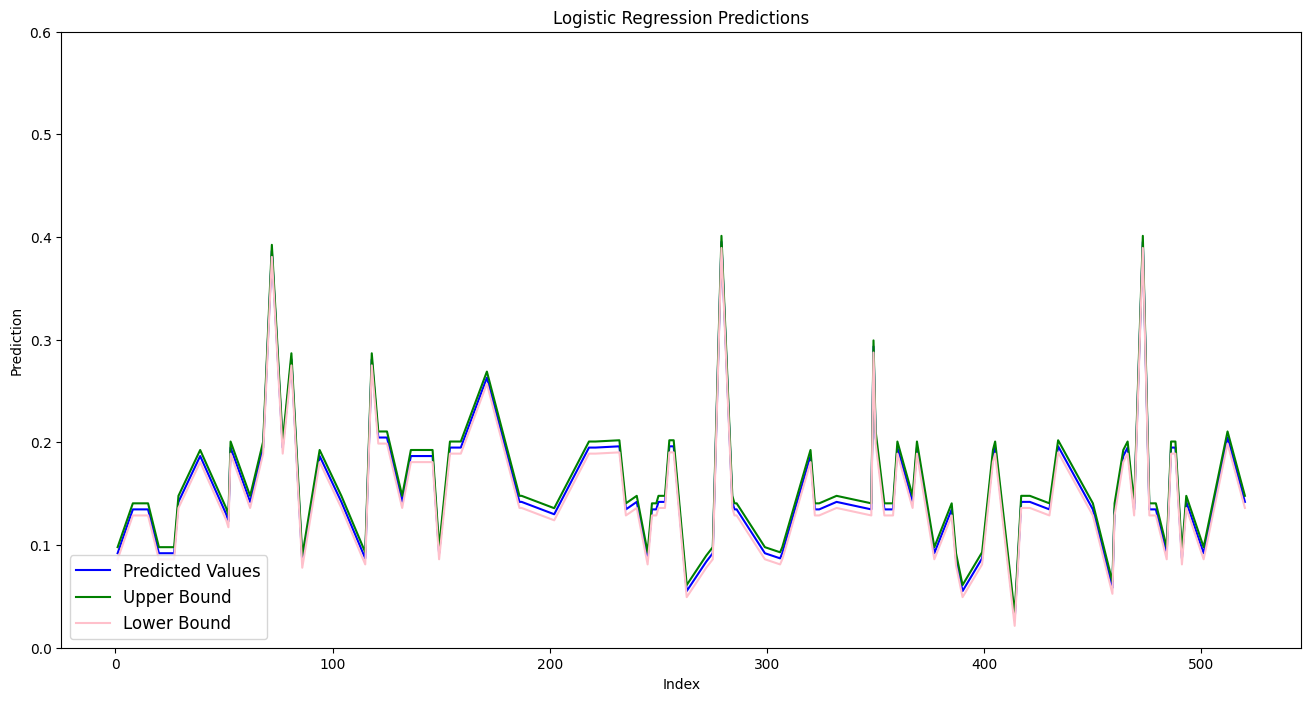

In [155]:
# To show a slice of  the data so that it's intelligible

df_first100 = sorted.iloc[0:100]
# Make a plot of model fit

fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(111)


x = plot_df.index.values

plt.title('Logistic Regression Predictions')

plt.xlabel('Index')
plt.ylabel('Prediction')

upper = df_first100['Upper Bound']
lower = df_first100['Lower Bound']

df_first100['Predicted'].plot(color = 'blue', label = 'Predicted Values')
upper.plot(color = 'green', label = 'Upper Bound')
lower.plot(color = 'pink', label = 'Lower Bound')

# plot the legend for the first plot
plt.legend(loc = 'lower left', fontsize = 12)

plt.ylim(0,0.6)

plt.show()
